In [74]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import random
import arviz as az
import geopandas
import folium
import collections
import mapclassify
import math
import seaborn as sns

# Load regional model

In [38]:
regional_model = pd.read_pickle('../output/models/bayes_models/tfp_bayes_yfe_rre_for_drought_full/tfp_bayes_yfe_rre_for_drought_full.pkl')
posterior = regional_model["posterior"]
trace = regional_model["trace"]
var_list = regional_model["var_list"]
model_spec = regional_model["model_spec"]
model_vars = ["global_region_rs_mean","global_region_rs_sd","region_rs_means","region_rs_sd","region_rs_coefs","model_variable_coefs","tfp_std","tfp_std_scale"]

# Convergence checks

/tmp/ipykernel_15964/2942097797.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


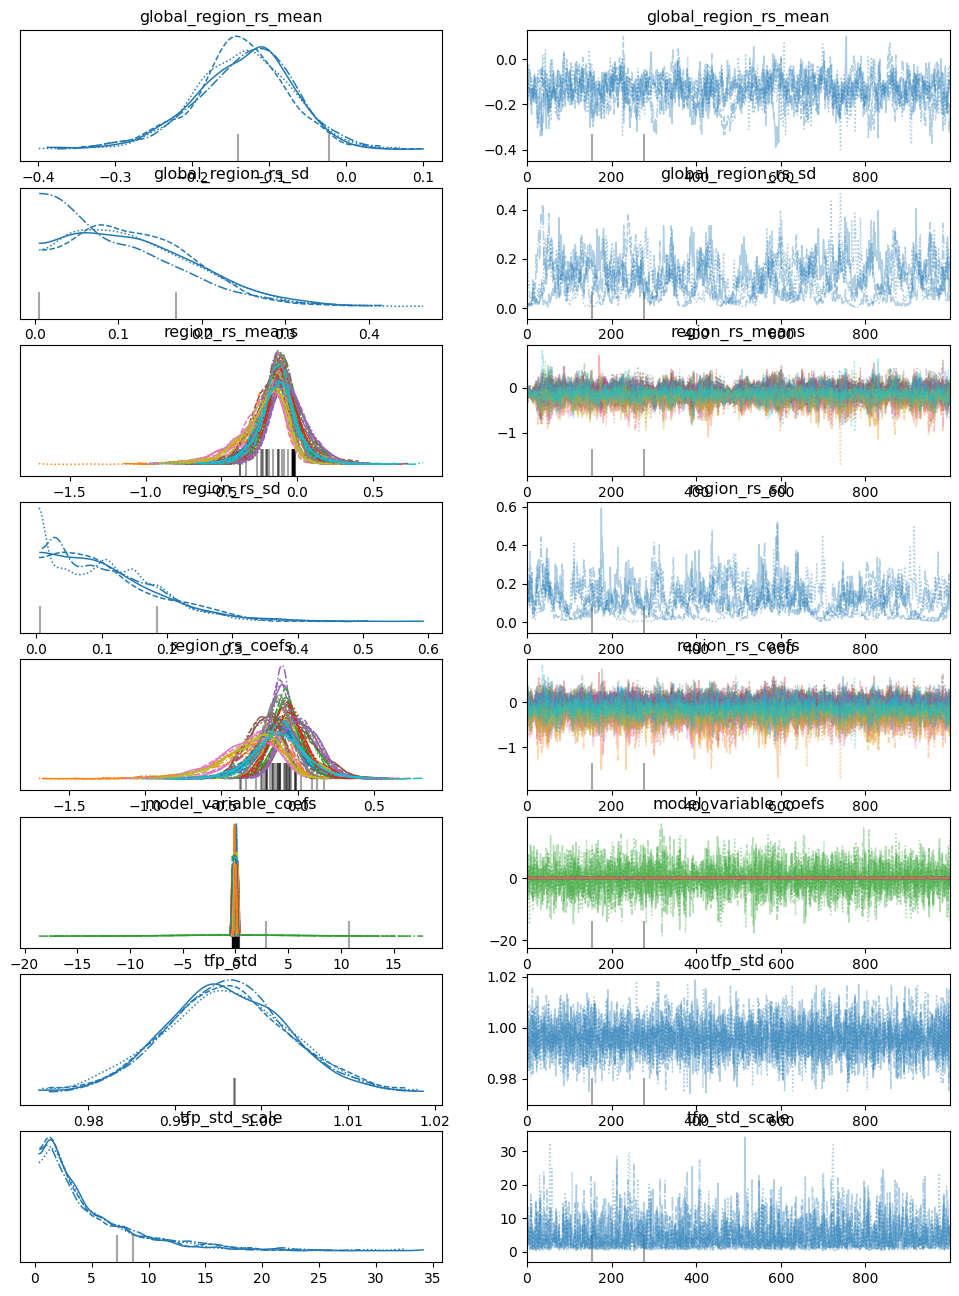

In [15]:
fig = az.plot_trace(trace, var_names=model_vars).ravel()[0].figure
fig.show()

In [17]:
az.summary(trace, var_names=model_vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_region_rs_mean,-0.135,0.064,-0.259,-0.017,0.003,0.002,389.0,522.0,1.01
global_region_rs_sd,0.116,0.076,0.005,0.246,0.006,0.004,156.0,225.0,1.02
"region_rs_means[0, 0]",-0.113,0.126,-0.350,0.148,0.005,0.004,631.0,865.0,1.00
"region_rs_means[0, 1]",-0.145,0.119,-0.387,0.076,0.003,0.003,1156.0,1180.0,1.00
"region_rs_means[0, 2]",-0.074,0.123,-0.279,0.188,0.005,0.004,486.0,668.0,1.00
...,...,...,...,...,...,...,...,...,...
model_variable_coefs[59],0.017,0.078,-0.136,0.154,0.001,0.001,5368.0,2698.0,1.00
model_variable_coefs[60],0.057,0.077,-0.078,0.214,0.001,0.001,5985.0,2464.0,1.00
model_variable_coefs[61],0.020,0.080,-0.127,0.175,0.001,0.001,4821.0,2912.0,1.00
tfp_std,0.996,0.007,0.983,1.010,0.000,0.000,6900.0,2879.0,1.00


In [16]:
for index, r_hat in enumerate(az.summary(trace, var_names=model_vars)["r_hat"]):
    if r_hat > 1.05:
        print(index, r_hat)

# Unscale regional drought coefficients

In [39]:
tfp_regression_data = pd.read_csv("../data/regression/tfp_regression_data.csv").dropna().reset_index(drop=True)
scaled_vars = {}
unscaled_vars = {}
for index, var in enumerate(var_list[-20:]):
    scaled_vars[var] = posterior.posterior.region_rs_coefs[:,:,:,index].data.flatten()
for var, samples in scaled_vars.items():
    unscaled_vars[var] = np.array(samples) * np.std(tfp_regression_data.fd_ln_tfp)

# Make map with regional slopes

/tmp/ipykernel_4852/2720742492.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_4852/2720742492.py:36: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')


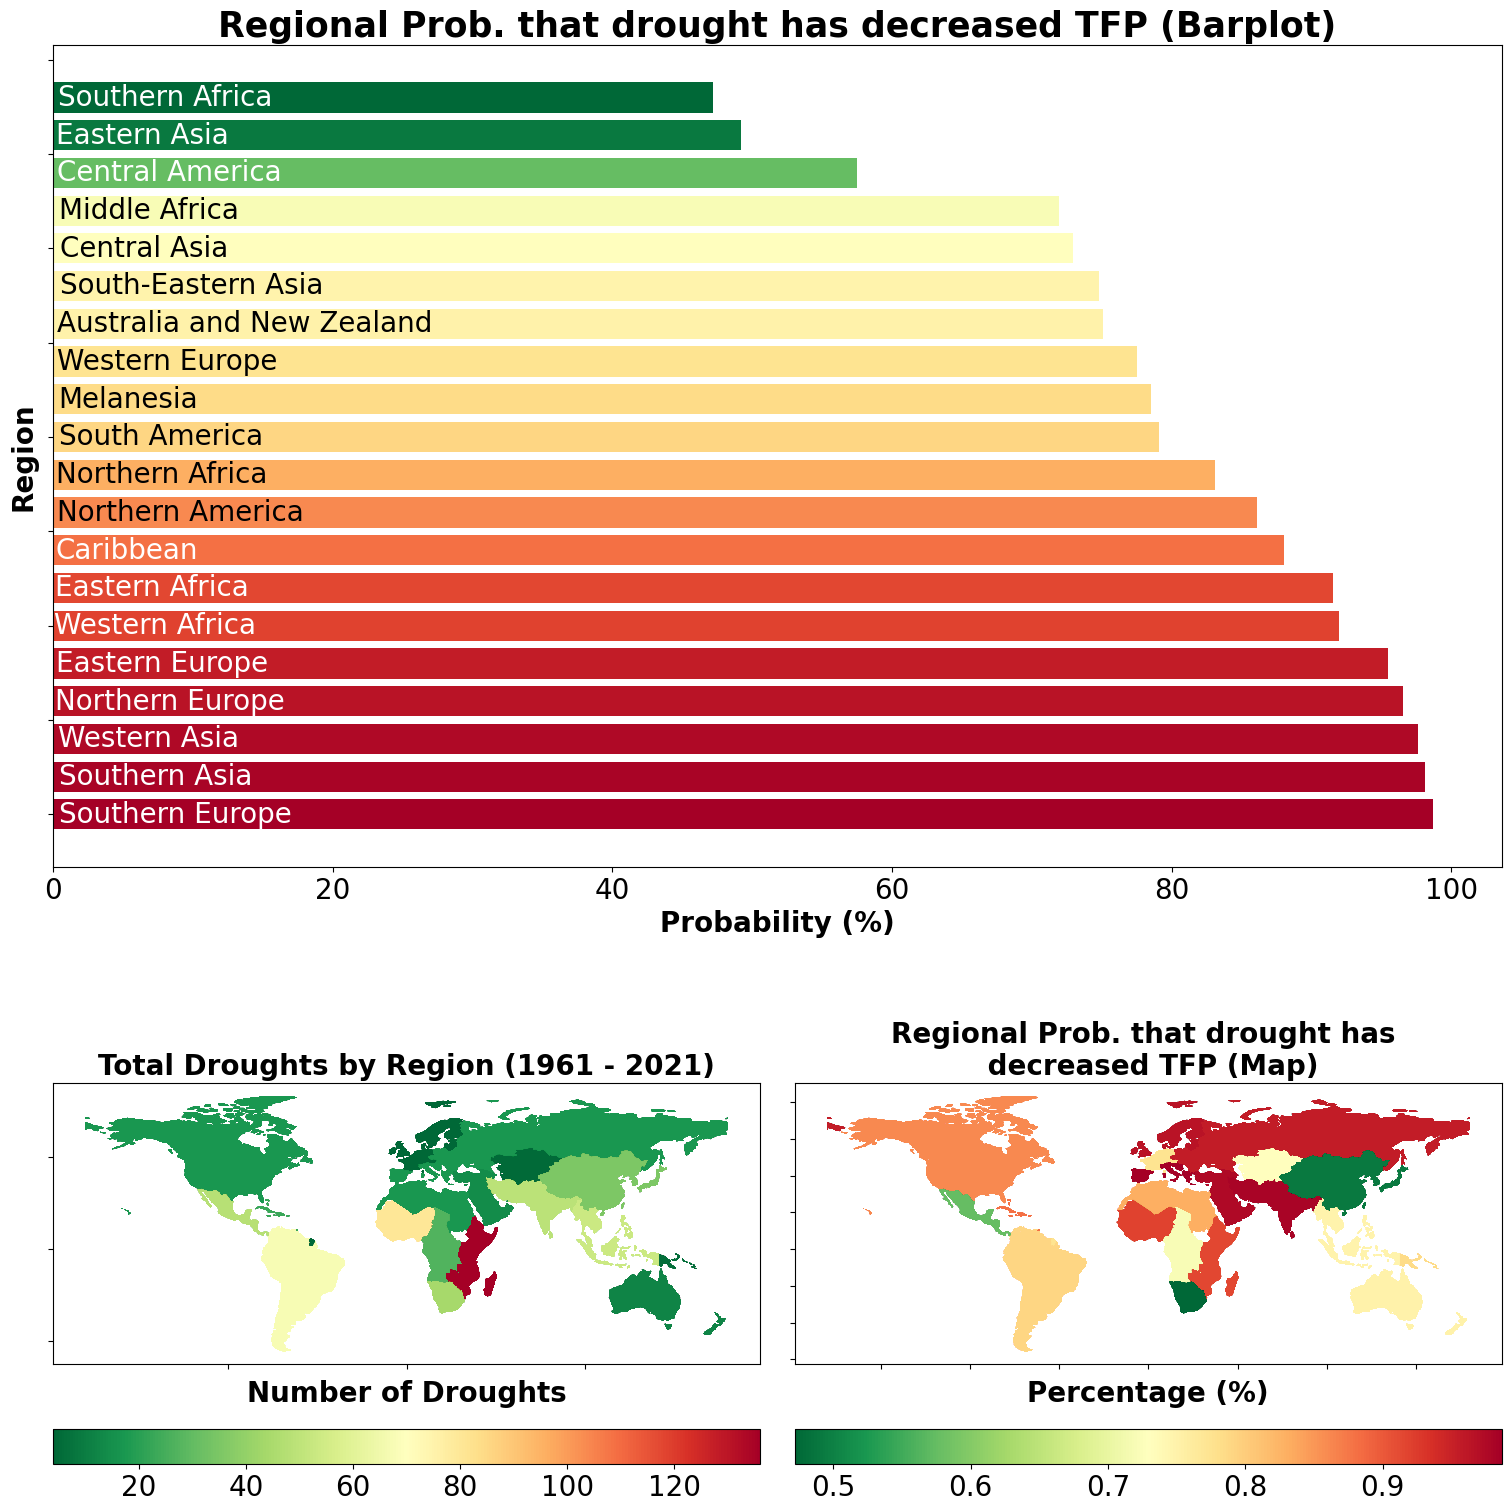

In [36]:
res = az.summary(trace, var_names=["region_rs_coefs"])
region_percentiles = {}
for index, region in enumerate(var_list[-20:]):
    region_percentiles[region.split("_")[0]] = len([sample for sample in unscaled_vars[region] if sample < 0])/len(unscaled_vars[region])
tfp_regression_data["drought_bin"] = list(map(lambda x : region_percentiles[x], tfp_regression_data.region23))

# % chance region negatively affected

fig = plt.figure(constrained_layout=True, figsize=(15,15))
axs = fig.subplot_mosaic([['Top', 'Top'],['BottomLeft', 'BottomRight']], gridspec_kw={'width_ratios':[1,1], 'height_ratios':[1,.5]})

# total droughts by region
droughts_by_region = {}
for region in set(tfp_regression_data.region23):
    droughts_by_region[region] = np.count_nonzero(tfp_regression_data.loc[(tfp_regression_data.region23 == region)].drought)
tfp_regression_data["total_drought_by_region"] = list(map(lambda x : droughts_by_region[x], tfp_regression_data.region23))

country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
country_geopandas = country_geopandas.merge(
    tfp_regression_data,
    how='inner', 
    left_on=['iso_a3'],
    right_on=['country']
)
res = country_geopandas.plot(column="total_drought_by_region", cmap="RdYlGn_r", ax=axs["BottomLeft"], legend=True, legend_kwds={"location":"bottom"})
axs["BottomLeft"].set_title("Total Droughts by Region (1961 - 2021)", size=20, weight="bold")
axs["BottomLeft"].set_xticklabels([])
axs["BottomLeft"].set_yticklabels([])
axs["BottomLeft"].set_xlabel("Number of Droughts", size=20, weight="bold")
axs["BottomLeft"].figure.axes[1].tick_params(labelsize=50)
res.figure.axes[-1].tick_params(labelsize=20)

country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
country_geopandas = country_geopandas.merge(
    tfp_regression_data,
    how='inner',
    left_on=['iso_a3'],
    right_on=['country']
)
res = country_geopandas.plot(column="drought_bin", cmap="RdYlGn_r", ax=axs["BottomRight"], legend=True, legend_kwds={"location":"bottom"})
cmap = plt.get_cmap('RdYlGn_r')
norm = mcolors.Normalize(vmin=country_geopandas['drought_bin'].min(), vmax=country_geopandas['drought_bin'].max())
colors = [cmap(norm(value)) for value in country_geopandas['drought_bin']]
axs["BottomRight"].set_title("Regional Prob. that drought has \n decreased TFP (Map)", size=20, weight="bold")
axs["BottomRight"].set_xlabel("Percentage (%)", size=20, weight="bold")
axs["BottomRight"].set_xticklabels([])
axs["BottomRight"].set_yticklabels([])
res.figure.axes[-1].tick_params(labelsize=20)

sorted_region_percentiles = dict(sorted(region_percentiles.items(), key=lambda x: x[1], reverse=True))
region_colors = []
for region in sorted_region_percentiles.keys():
    region_index = country_geopandas.loc[country_geopandas.region23 == region].index[0]
    region_colors.append(colors[region_index])

barcounts = [val*100 for val in list(sorted_region_percentiles.values())]
barplot = axs["Top"].barh(list(range(0,20)), barcounts, color=region_colors)
barcolors = ["white","white","white","white","white","white","white","white","black","black","black","black","black","black","black","black","black","white","white","white"]
barlabels = axs["Top"].bar_label(barplot, list(sorted_region_percentiles.keys()), label_type = "center")
barpaddings = list(reversed([43,17,-6,-93,-102,-77,-40,-108,-141,-120,-140,-142,-190,-190,-190,-202,-202,-223,-220,-209]))
for index, bar_label in enumerate(barlabels):
    bar_label.set_x(bar_label.get_position()[1] - 200 + barpaddings[index])
for i, text in enumerate(axs["Top"].texts):
    text.set_color(barcolors[i])
    text.set_size(20)
axs["Top"].set_title("Regional Prob. that drought has decreased TFP (Barplot)", size=25, weight="bold")
axs["Top"].set_xlabel("Probability (%)", weight="bold", size=20)
axs["Top"].set_ylabel("Region", weight="bold", size=20)
axs["Top"].set_yticklabels([])
axs["Top"].xaxis.set_tick_params(labelsize=20)

plt.savefig("../figures/drought_fig1.png", bbox_inches='tight')

In [37]:
print(np.mean(tfp_regression_data["drought_bin"]))
print(np.std(tfp_regression_data["drought_bin"]))

0.8365303706063502
0.14661348984483644


# Regional production deficit from drought

/tmp/ipykernel_5272/405726079.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_5272/405726079.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')
/tmp/ipykernel_5272/405726079.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_5272/405726079.py:61: MatplotlibDeprecationWarning: The get_cmap function was de

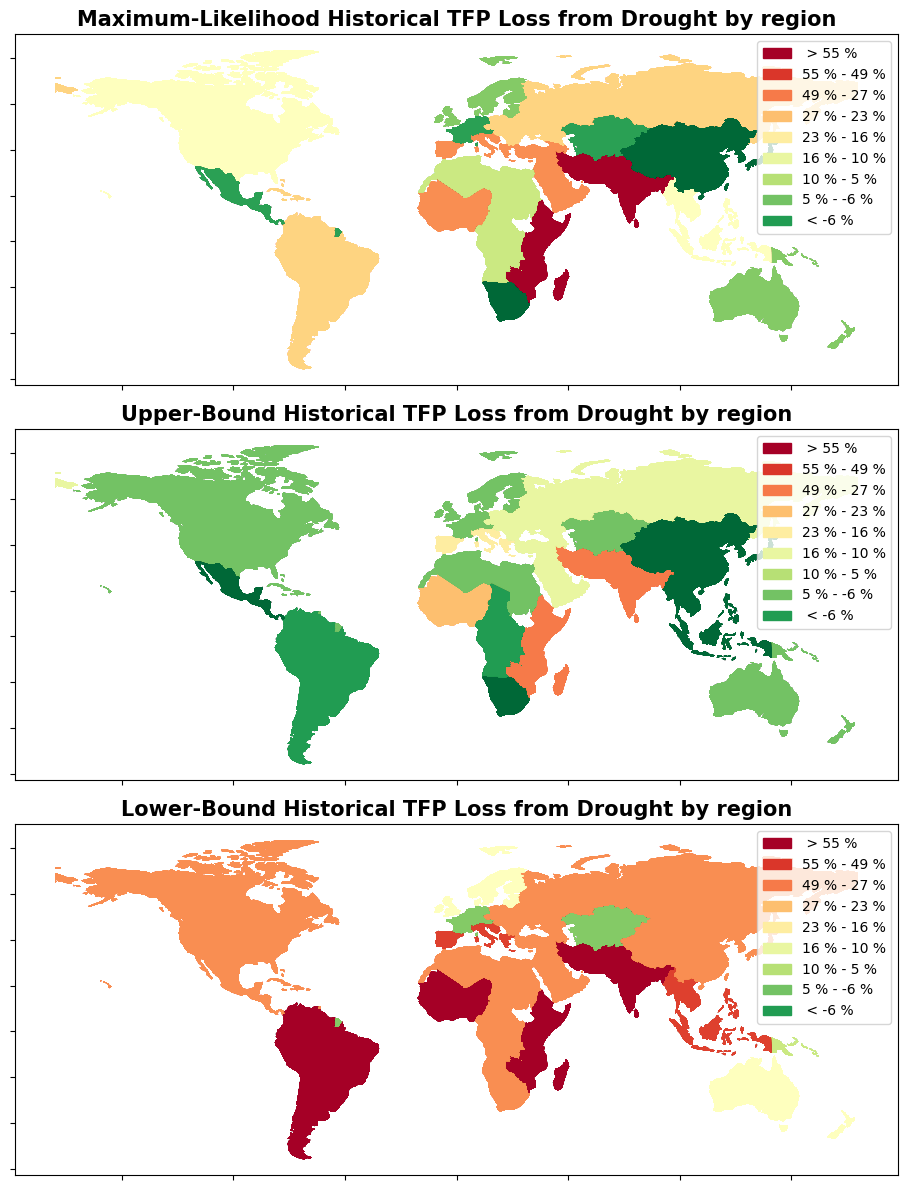

In [179]:
effect_by_region = {}
for region in set(tfp_regression_data.region23):
    effect_by_region[region] = [0]*4000
    for i in range(droughts_by_region[region]):
        effect_by_region[region] += unscaled_vars[region+"_region_fixed_effect"]

percent_loss_by_region = {
    region:np.array([math.expm1(val)*100 for val in effect_by_region[region]])
    for region in set(tfp_regression_data.region23)
}

fig, axis = plt.subplots(3,1, figsize=(12,12))

axes = [axis[0], axis[1], axis[2]]
thresholds = [None, .84, .16]
threshold_labels = ["Maximum-Likelihood", "Upper-Bound", "Lower-Bound"]

for threshold, label, axis in zip(thresholds, threshold_labels, axes):
    region_percent_loss = {}
    for region, samples in percent_loss_by_region.items():
        sorted_samples = sorted(samples)
        if threshold != None:
            region_percent_loss[region] = np.quantile(sorted_samples, threshold)
        else:
            region_percent_loss[region] = np.mean(sorted_samples)
    
    tfp_regression_data[f"region_percent_loss_{label}"] = list(map(lambda x : region_percent_loss[x], tfp_regression_data.region23))
    
    region_geopandas = geopandas.read_file(
        geopandas.datasets.get_path('naturalearth_lowres')
    )
    region_geopandas = region_geopandas.merge(
        tfp_regression_data,
        how='inner',
        left_on=['iso_a3'],
        right_on=['country']
    )
    bins = list(mapclassify.Quantiles(region_geopandas[f'region_percent_loss_Maximum-Likelihood'], k=10).bins)
    # delete bins that have similar range for map readability
    bins_to_remove = []
    for index, bin in enumerate(bins):
        if index != 0:
            if int(str(bin).split(".")[0]) == int(str(bins[index-1]).split(".")[0]):
                bins_to_remove.append(index)
    bins = [val for index, val in enumerate(bins) if index not in bins_to_remove]
    legend_labels = []
    bins_as_int = [-1*int(str(bin).split(".")[0]) for bin in bins]
    for index, bin in enumerate(bins_as_int):
        if index == 0:
            legend_labels.append(f" > {bin} %")
        elif index == len(bins_as_int) - 1:
            legend_labels.append(f" < {bins_as_int[index-1]} %")
            break
        else:
            legend_labels.append(f"{bins_as_int[index-1]} % - {bin} %")
    region_geopandas.plot(column=f'region_percent_loss_{label}', cmap='RdYlGn', scheme="User_Defined", 
             legend=True, classification_kwds=dict(bins=bins), ax=axis)

    cmap = cm.get_cmap('RdYlGn')
    legend_bins = []
    for index, legend_label in enumerate(legend_labels):
        legend_bins.append(mpatches.Patch(color=cmap((1/len(legend_labels)*index)), label=legend_label))
    axis.legend(handles=legend_bins)
    
    axis.set_title(f"{label} Historical TFP Loss from Drought by region", size=15, weight="bold")
    axis.set_yticklabels([])
    axis.set_xticklabels([])

plt.tight_layout()
plt.savefig("../figures/drought_fig2.png", bbox_inches='tight')

# Load country model

In [75]:
country_model = pd.read_pickle('../output/models/bayes_models/tfp_bayes_yfe_cre_for_drought_full/tfp_bayes_yfe_cre_for_drought_full_10k.pkl')
posterior = country_model["posterior"]
trace = country_model["trace"]
var_list = country_model["var_list"]
model_spec = country_model["model_spec"]
model_vars = ["global_country_rs_mean","global_country_rs_sd","country_rs_means","country_rs_sd","country_rs_coefs","model_variable_coefs","tfp_std","tfp_std_scale"]

# Convergence checks

/tmp/ipykernel_3077/2942097797.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


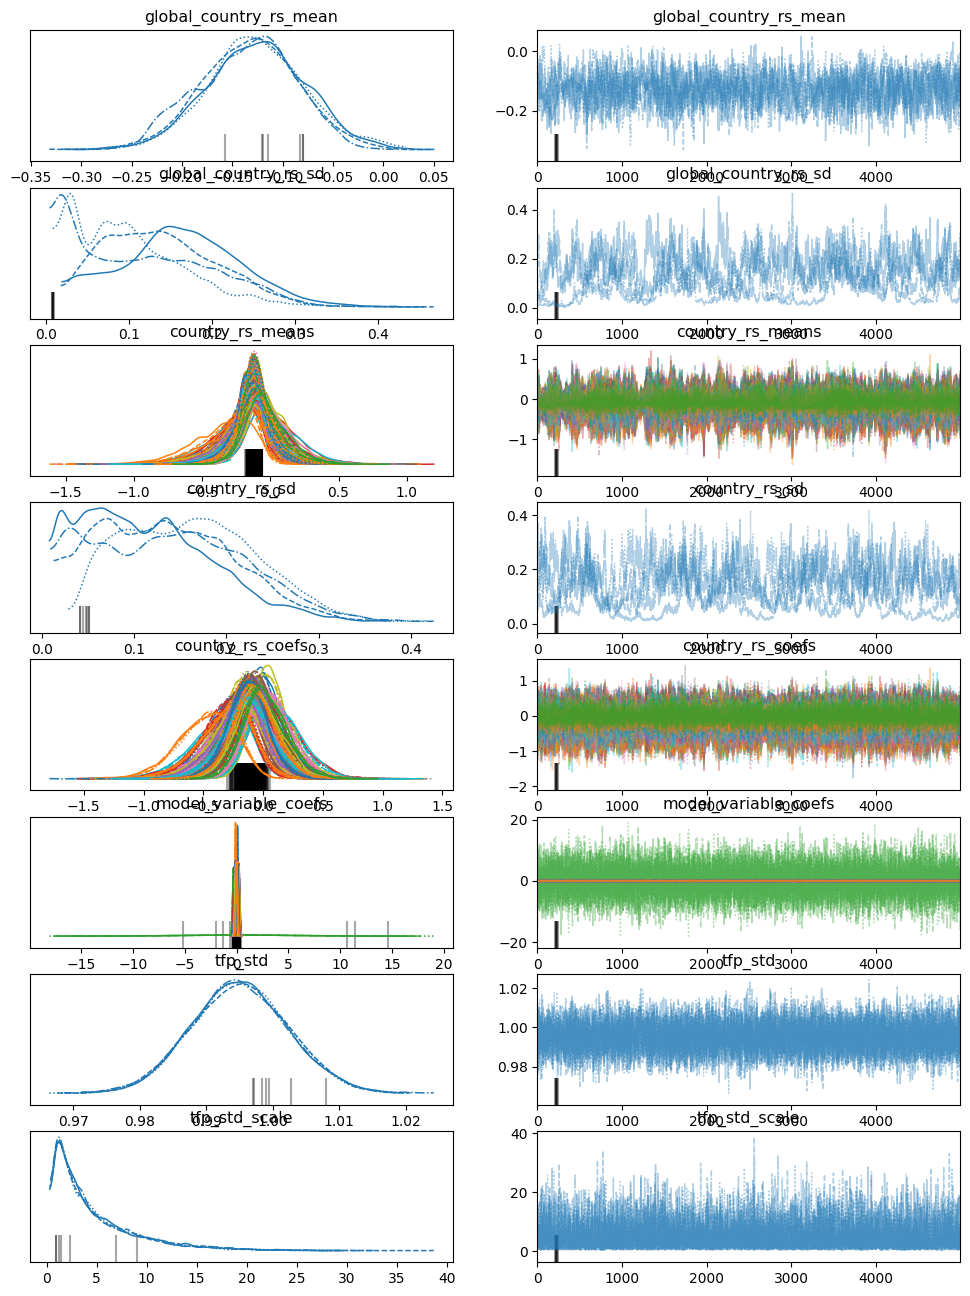

In [3]:
fig = az.plot_trace(trace, var_names=model_vars).ravel()[0].figure
fig.show()

In [4]:
az.summary(trace, var_names=model_vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_country_rs_mean,-0.130,0.049,-0.222,-0.040,0.002,0.001,799.0,1449.0,1.01
global_country_rs_sd,0.128,0.076,0.005,0.255,0.012,0.009,35.0,51.0,1.08
"country_rs_means[0, 0]",-0.208,0.157,-0.529,0.053,0.007,0.006,684.0,1624.0,1.01
"country_rs_means[0, 1]",-0.145,0.138,-0.422,0.122,0.002,0.003,4132.0,2487.0,1.02
"country_rs_means[0, 2]",-0.119,0.153,-0.421,0.186,0.002,0.003,6441.0,2364.0,1.02
...,...,...,...,...,...,...,...,...,...
model_variable_coefs[59],0.019,0.078,-0.128,0.165,0.000,0.001,26593.0,11385.0,1.00
model_variable_coefs[60],0.054,0.078,-0.096,0.201,0.000,0.001,27032.0,12942.0,1.00
model_variable_coefs[61],0.017,0.078,-0.127,0.166,0.000,0.001,26534.0,13301.0,1.00
tfp_std,0.995,0.007,0.982,1.009,0.000,0.000,24793.0,13513.0,1.00


In [5]:
model_summary = az.summary(trace, var_names=model_vars)
for index, r_hat in enumerate(model_summary["r_hat"]):
    if r_hat > 1.05:
        print(model_summary.index[index], r_hat)

global_country_rs_sd 1.08
country_rs_sd 1.06


# Unscale country droughts coefficients

In [76]:
tfp_regression_data = pd.read_csv("../data/regression/tfp_regression_data.csv").dropna().reset_index(drop=True)
scaled_vars = {}
unscaled_vars = {}
for index, var in enumerate(var_list[-163:]):
    scaled_vars[var] = posterior.posterior.country_rs_coefs[:,:,:,index].data.flatten()
for var, samples in scaled_vars.items():
    unscaled_vars[var] = np.array(samples) * np.std(tfp_regression_data.fd_ln_tfp)

# Make map with country slopes

/tmp/ipykernel_4852/3053981384.py:18: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_4852/3053981384.py:40: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')


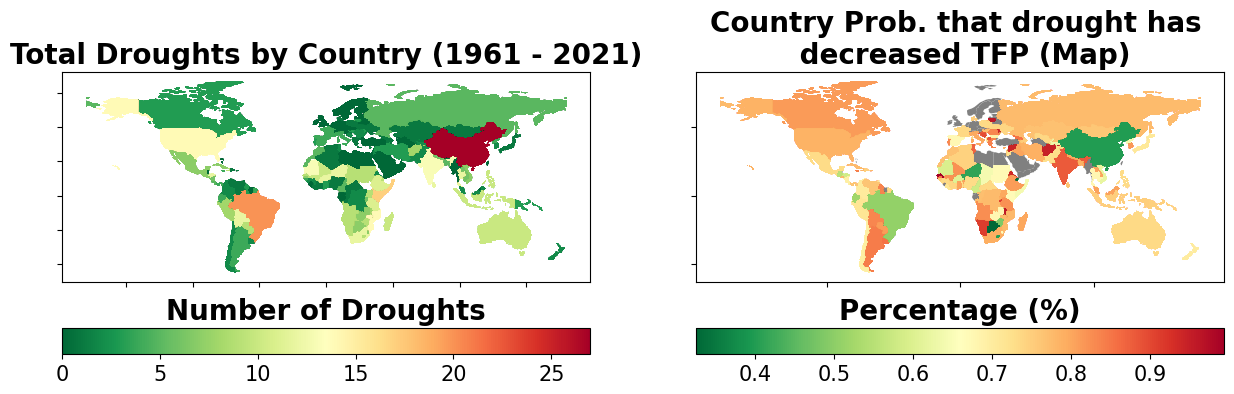

In [77]:
res = az.summary(trace, var_names=["country_rs_coefs"])
country_percentiles = {}
for index, country in enumerate(list(var_list[-163:])):
    country_percentiles[country.split("_")[0]] = len([sample for sample in unscaled_vars[country] if sample < 0])/len(unscaled_vars[country])
tfp_regression_data["drought_bin"] = list(map(lambda x : country_percentiles[x], tfp_regression_data.country))

# % chance region negatively affected

fig, axes = plt.subplots(1,2,figsize=(15,15))

# total droughts by country
droughts_by_country = {}
for country in set(tfp_regression_data.country):
    droughts_by_country[country] = np.count_nonzero(tfp_regression_data.loc[(tfp_regression_data.country == country)].drought)
tfp_regression_data["total_drought_by_country"] = list(map(lambda x : droughts_by_country[x], tfp_regression_data.country))

country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
country_geopandas = country_geopandas.merge(
    tfp_regression_data,
    how='inner', 
    left_on=['iso_a3'],
    right_on=['country']
)
res = country_geopandas.plot(column="total_drought_by_country", cmap="RdYlGn_r", ax=axes[0], legend=True, legend_kwds={"location":"bottom", "pad":.04})
axes[0].set_title("Total Droughts by Country (1961 - 2021)", size=20, weight="bold")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_xlabel("Number of Droughts", size=20, weight="bold")
axes[0].figure.axes[1].tick_params(labelsize=50)
res.figure.axes[-1].tick_params(labelsize=15)

countries_with_no_drought = []
for country in set(tfp_regression_data.country):
    if all(tfp_regression_data[tfp_regression_data.country == country].drought == 0):
        countries_with_no_drought.append(country)

country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
tfp_regression_data_ndcr = tfp_regression_data[~tfp_regression_data.country.isin(countries_with_no_drought)]
country_geopandas[country_geopandas.iso_a3.isin(countries_with_no_drought)].plot(color='gray', ax=axes[1])
country_geopandas = country_geopandas.merge(
    tfp_regression_data_ndcr,
    how='inner',
    left_on=['iso_a3'],
    right_on=['country']
)
res = country_geopandas.plot(column="drought_bin", cmap="RdYlGn_r", ax=axes[1], legend=True, legend_kwds={"location":"bottom", "pad":.04})

cmap = plt.get_cmap('RdYlGn_r')
norm = mcolors.Normalize(vmin=country_geopandas['drought_bin'].min(), vmax=country_geopandas['drought_bin'].max())
colors = [cmap(norm(value)) for value in country_geopandas['drought_bin']]
axes[1].set_title("Country Prob. that drought has \n decreased TFP (Map)", size=20, weight="bold")
axes[1].set_xlabel("Percentage (%)", size=20, weight="bold")
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
res.figure.axes[-1].tick_params(labelsize=15)

plt.savefig("../figures/drought_fig3.png", bbox_inches='tight')

In [33]:
print(np.mean(tfp_regression_data["drought_bin"]))
print(np.std(tfp_regression_data["drought_bin"]))

0.7430231124561963
0.10405663567530662


# Make map with percentage lost by country

/tmp/ipykernel_4852/1675697109.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_4852/1675697109.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')
/tmp/ipykernel_4852/1675697109.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_4852/1675697109.py:62: MatplotlibDeprecationWarning: The get_cmap function wa

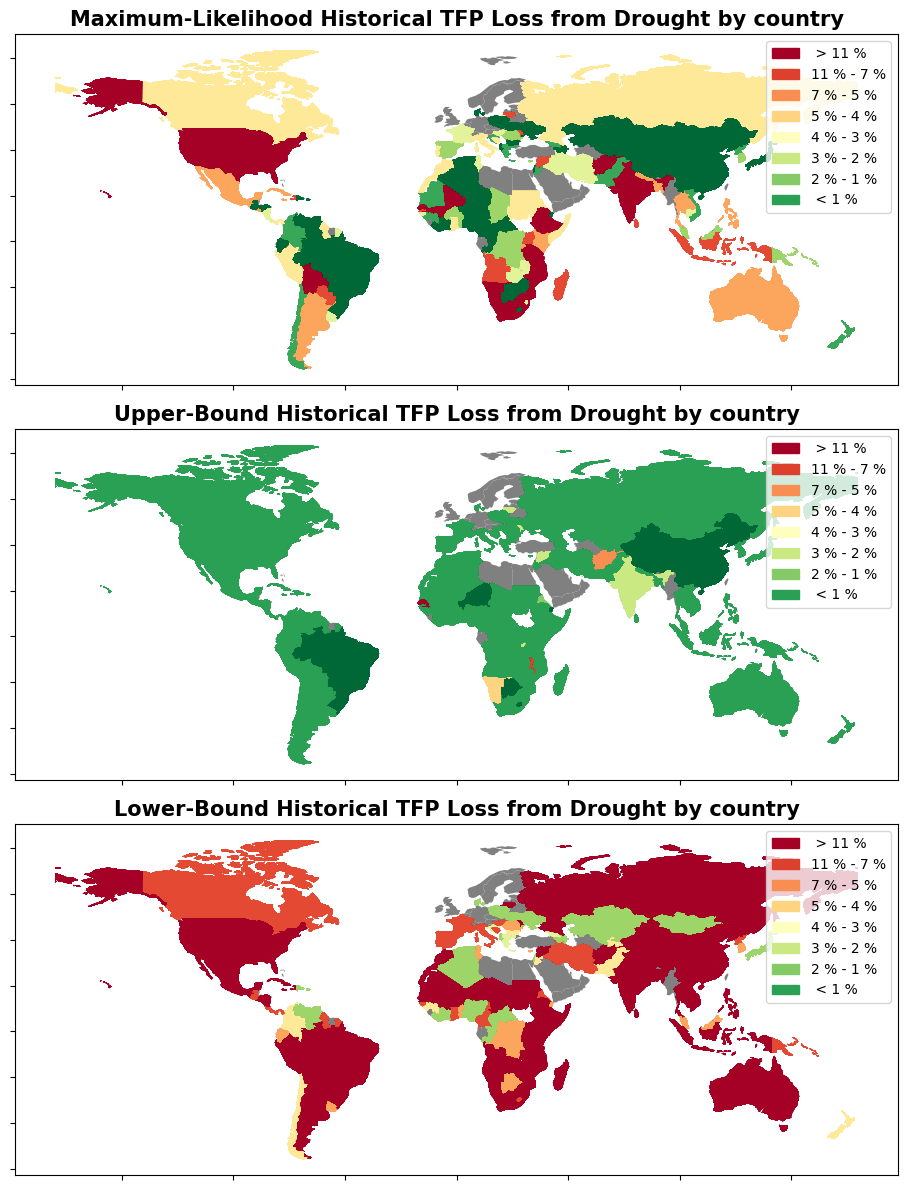

In [78]:
# % production deficit from drought
effect_by_country = {}
for country in set(tfp_regression_data.country):
    effect_by_country[country] = [0]*len(unscaled_vars["AFG_country_fixed_effect"])
    for i in range(droughts_by_country[country]):
        effect_by_country[country] += unscaled_vars[country+"_country_fixed_effect"]

percent_loss_by_country = {
    country:np.array([math.expm1(val)*100 for val in effect_by_country[country]])
    for country in set(tfp_regression_data.country)
}

fig, axis = plt.subplots(3,1, figsize=(12,12))

axes = [axis[0], axis[1], axis[2]]
thresholds = [None, .84, .16]
threshold_labels = ["Maximum-Likelihood", "Upper-Bound", "Lower-Bound"]

for threshold, label, axis in zip(thresholds, threshold_labels, axes):
    country_percent_loss = {}
    for country, samples in percent_loss_by_country.items():
        sorted_samples = sorted(samples)
        if threshold != None:
            country_percent_loss[country] = np.quantile(sorted_samples, threshold)
        else:
            country_percent_loss[country] = np.mean(sorted_samples)
    
    tfp_regression_data[f"country_percent_loss_{label}"] = list(map(lambda x : country_percent_loss[x], tfp_regression_data.country))
    tfp_regression_data_ndcr = tfp_regression_data[~tfp_regression_data.country.isin(countries_with_no_drought)]
    
    country_geopandas = geopandas.read_file(
        geopandas.datasets.get_path('naturalearth_lowres')
    )
    country_geopandas[country_geopandas.iso_a3.isin(countries_with_no_drought)].plot(color='gray', ax=axis)
    country_geopandas = country_geopandas.merge(
        tfp_regression_data_ndcr,
        how='inner',
        left_on=['iso_a3'],
        right_on=['country']
    )
    bins = list(mapclassify.Quantiles(country_geopandas[f"country_percent_loss_Maximum-Likelihood"], k=10).bins)
    # delete bins that have similar range for map readability
    bins_to_remove = []
    for index, bin in enumerate(bins):
        if index != 0:
            if round(bin) == round(bins[index-1]):
                bins_to_remove.append(index)
    bins = [val for index, val in enumerate(bins) if index not in bins_to_remove]
    legend_labels = []
    bins_as_int = [-1*round(bin) for bin in bins]
    for index, bin in enumerate(bins_as_int):
        if index == 0:
            legend_labels.append(f" > {bin} %")
        elif index == len(bins_as_int) - 1:
            legend_labels.append(f" < {bins_as_int[index-1]} %")
            break
        else:
            legend_labels.append(f"{bins_as_int[index-1]} % - {bin} %")
    
    country_geopandas.plot(column=f"country_percent_loss_{label}", cmap='RdYlGn', scheme="User_Defined", classification_kwds=dict(bins=bins), ax=axis)
    
    cmap = cm.get_cmap('RdYlGn')
    legend_bins = []
    for index, legend_label in enumerate(legend_labels):
        legend_bins.append(mpatches.Patch(color=cmap((1/len(legend_labels)*index)), label=legend_label))
    axis.legend(handles=legend_bins)
    
    axis.set_title(f"{label} Historical TFP Loss from Drought by country", size=15, weight="bold")
    axis.set_yticklabels([])
    axis.set_xticklabels([])

plt.tight_layout()
plt.savefig("../figures/drought_fig4.png", bbox_inches='tight')

# Global Results

In [98]:
revenue_data = pd.read_csv("../data/revenue_shares.csv")
country_weights = {}
for row in revenue_data.itertuples():
    if row[3] in set(tfp_regression_data.country):
        country_weights[row[3]] = np.mean([row[5],row[6],row[7],row[8],row[9],row[10]])
weight_sum = sum(list(country_weights.values()))
for country, val in country_weights.items():
    country_weights[country] = val/weight_sum

global_effect = [0]*len(unscaled_vars["AFG_country_fixed_effect"])
for country in set(tfp_regression_data.country):
    country_effect = [0]*len(unscaled_vars["AFG_country_fixed_effect"])
    for i in range(droughts_by_country[country]):
        country_effect += unscaled_vars[country+"_country_fixed_effect"] * country_weights[country]
    global_effect += country_effect

print(len([math.expm1(val)*100 for val in global_effect if val < 0])/20000)

# global_percent_loss_by_country = {
#     country:np.array([math.expm1(val)*100 for val in effect_by_country[country]])
#     for country in set(tfp_regression_data.country)
# }

# global_loss = [0] * len(unscaled_vars["AFG_country_fixed_effect"])
# for country, loss in percent_loss_by_country.items():
#     global_loss += loss * country_weights[country]

# print(len([val for val in global_loss if val < 0])/20000)

# data = [math.expm1(val)*100 for val in posterior.posterior.global_region_rs_mean.data.flatten()]
# q1 = np.quantile(data, .16)
# q2 = np.quantile(data, .84)
# fig, ax = plt.subplots()
# _, bins, patches = ax.hist(data, bins=100, density=True)
# sns.kdeplot(data, ax=ax, color="black")
# ax.axvline(q1, color = "blue", linewidth=4)
# ax.axvline(q2, color = "blue", linewidth=4)
# ax.axvline(0, color = "orange", linewidth=4)
# ax.axvline(np.mean(data), color = "green", linewidth=4)
# for index, bin in enumerate(bins):
#     if index != len(bins)-1:
#         if bin < q1 or bin > q2:
#             patches[index].set_facecolor("gray")
#         else:
#             patches[index].set_facecolor("red")

# plt.xlabel("% Global TFP Decrease due to Drought", size=15, weight="bold")
# plt.ylabel("Probability Density", size=15, weight="bold")
# plt.savefig("../figures/drought_fig5.png", bbox_inches='tight')

0.7319


# Developed vs. Developing countries

In [42]:
developmental_model = pd.read_pickle('../output/models/bayes_models/tfp_bayes_yfe_dre_for_drought_full/tfp_bayes_yfe_dre_for_drought_full.pkl')
posterior = developmental_model["posterior"]
trace = developmental_model["trace"]
var_list = developmental_model["var_list"]
model_spec = developmental_model["model_spec"]
model_vars = ["global_development_rs_mean","global_development_rs_sd","development_rs_means","development_rs_sd","development_rs_coefs","model_variable_coefs","tfp_std","tfp_std_scale"]

/tmp/ipykernel_4852/2942097797.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


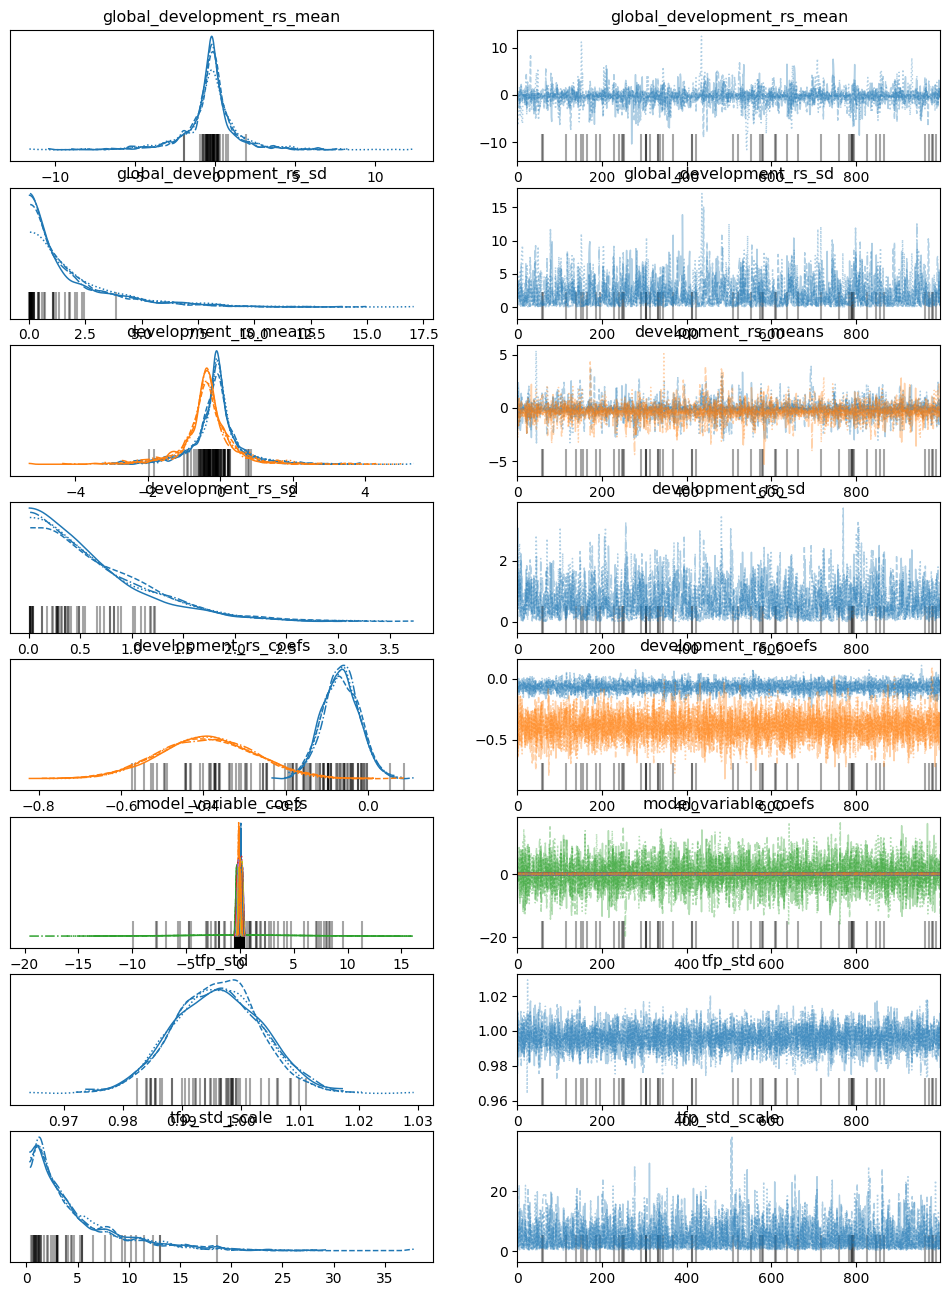

In [43]:
fig = az.plot_trace(trace, var_names=model_vars).ravel()[0].figure
fig.show()

In [44]:
az.summary(trace, var_names=model_vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_development_rs_mean,-0.280,1.679,-3.677,3.160,0.037,0.032,2388.0,1637.0,1.00
global_development_rs_sd,1.922,2.017,0.018,5.872,0.062,0.044,823.0,1087.0,1.01
"development_rs_means[0, 0]",-0.115,0.702,-1.611,1.301,0.014,0.012,2824.0,1680.0,1.00
"development_rs_means[0, 1]",-0.350,0.722,-1.833,1.067,0.014,0.012,3058.0,2233.0,1.00
development_rs_sd,0.657,0.544,0.005,1.651,0.016,0.012,824.0,961.0,1.00
...,...,...,...,...,...,...,...,...,...
model_variable_coefs[59],0.021,0.080,-0.120,0.182,0.001,0.001,6257.0,2924.0,1.00
model_variable_coefs[60],0.056,0.079,-0.101,0.197,0.001,0.001,6835.0,2180.0,1.00
model_variable_coefs[61],0.017,0.078,-0.129,0.165,0.001,0.001,7528.0,2788.0,1.00
tfp_std,0.996,0.007,0.983,1.010,0.000,0.000,6726.0,2821.0,1.00


In [45]:
model_summary = az.summary(trace, var_names=model_vars)
for index, r_hat in enumerate(model_summary["r_hat"]):
    if r_hat > 1.05:
        print(model_summary.index[index], r_hat)

In [66]:
tfp_regression_data = pd.read_csv("../data/regression/tfp_regression_data.csv").dropna().reset_index(drop=True)
scaled_vars = {}
unscaled_vars = {}
for index, var in enumerate(var_list[-2:]):
    scaled_vars[var] = posterior.posterior.development_rs_coefs[:,:,:,index].data.flatten()
for var, samples in scaled_vars.items():
    unscaled_vars[var] = np.array(samples) * np.std(tfp_regression_data.fd_ln_tfp)

In [67]:
country_development_classification = pd.read_csv("../data/developed_developing_countries_UN.csv")
country_development_classification = {row[1]["ISO-alpha3 Code"]:row[1]["Developed / Developing regions"] for row in country_development_classification.iterrows()}
# remove countries not classified as developed or developing
countries_to_remove = [country for country in set(tfp_regression_data.country) if country not in country_development_classification]
print("Removing:", countries_to_remove)
tfp_regression_data = tfp_regression_data[~tfp_regression_data.country.isin(countries_to_remove)]

development_classification = []
for row in tfp_regression_data.iterrows():
    row = row[1]
    development_classification.append(country_development_classification[row.country].lower())
tfp_regression_data["development"] = development_classification
tfp_regression_data["developing_development_fixed_effect"] = np.where(tfp_regression_data.development == "Developing", 1, 0)
tfp_regression_data["developed_development_fixed_effect"] = np.where(tfp_regression_data.development == "Developed", 1, 0)

Removing: ['TWN']


In [73]:
percent_loss_by_development

{'developing': array([-99.54173524, -94.63168607, -98.87326738, ..., -57.98614362,
        -72.57574885, -99.91654837]),
 'developed': array([-97.77667988, -60.11403855, -98.44104884, ..., -97.83298892,
        -86.99104101, -92.15354857])}

/tmp/ipykernel_4852/1474890641.py:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')


{'developing': -59.045151261985716, 'developed': -89.61970139547236}


ValueError: aspect must be finite and positive 

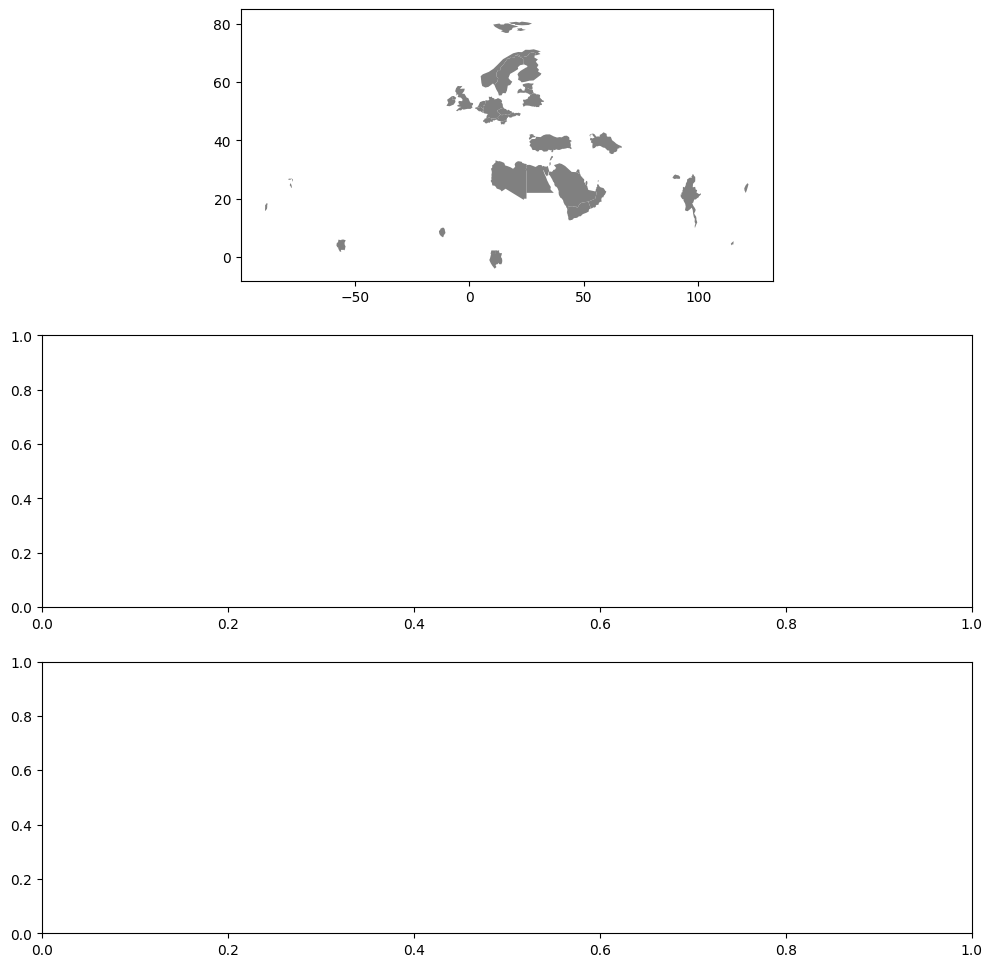

In [71]:
# total droughts by development
droughts_by_development = {}
for development in set(tfp_regression_data.development):
    droughts_by_development[development] = np.count_nonzero(tfp_regression_data.loc[(tfp_regression_data.development == development)].drought)
tfp_regression_data["total_drought_by_development"] = list(map(lambda x : droughts_by_development[x], tfp_regression_data.development))

effect_by_development = {}
for development in set(tfp_regression_data.development):
    effect_by_development[development] = [0]*len(unscaled_vars["developed_development_fixed_effect"])
    for i in range(droughts_by_development[development]):
        effect_by_development[development] += unscaled_vars[development+"_development_fixed_effect"]

percent_loss_by_development = {
    development:np.array([math.expm1(val)*100 for val in effect_by_development[development]])
    for development in set(tfp_regression_data.development)
}

fig, axis = plt.subplots(3,1, figsize=(12,12))

axes = [axis[0], axis[1], axis[2]]
thresholds = [None, .84, .16]
threshold_labels = ["Maximum-Likelihood", "Upper-Bound", "Lower-Bound"]

for threshold, label, axis in zip(thresholds, threshold_labels, axes):
    development_percent_loss = {}
    for development, samples in percent_loss_by_development.items():
        sorted_samples = sorted(samples)
        if threshold != None:
            development_percent_loss[development] = np.quantile(sorted_samples, threshold)
        else:
            development_percent_loss[development] = np.mean(sorted_samples)
    
    tfp_regression_data[f"development_percent_loss_{label}"] = list(map(lambda x : development_percent_loss[x], tfp_regression_data.development))
    tfp_regression_data_ndcr = tfp_regression_data[~tfp_regression_data.development.isin(countries_with_no_drought)]
    
    development_geopandas = geopandas.read_file(
        geopandas.datasets.get_path('naturalearth_lowres')
    )
    development_geopandas[development_geopandas.iso_a3.isin(countries_with_no_drought)].plot(color='gray', ax=axis)
    development_geopandas = development_geopandas.merge(
        tfp_regression_data_ndcr,
        how='inner',
        left_on=['iso_a3'],
        right_on=['development']
    )

    # bins = list(mapclassify.Quantiles(development_geopandas[f"development_percent_loss_Maximum-Likelihood"], k=10).bins)
    # # delete bins that have similar range for map readability
    # bins_to_remove = []
    # for index, bin in enumerate(bins):
    #     if index != 0:
    #         if round(bin) == round(bins[index-1]):
    #             bins_to_remove.append(index)
    # bins = [val for index, val in enumerate(bins) if index not in bins_to_remove]
    # legend_labels = []
    # bins_as_int = [-1*round(bin) for bin in bins]
    # for index, bin in enumerate(bins_as_int):
    #     if index == 0:
    #         legend_labels.append(f" > {bin} %")
    #     elif index == len(bins_as_int) - 1:
    #         legend_labels.append(f" < {bins_as_int[index-1]} %")
    #         break
    #     else:
    #         legend_labels.append(f"{bins_as_int[index-1]} % - {bin} %")
    
    # development_geopandas.plot(column=f"development_percent_loss_{label}", cmap='RdYlGn', scheme="User_Defined", classification_kwds=dict(bins=bins), ax=axis)
    development_geopandas.plot(column=f"development_percent_loss_{label}", cmap='RdYlGn', ax=axis)
    
    # cmap = cm.get_cmap('RdYlGn')
    # legend_bins = []
    # for index, legend_label in enumerate(legend_labels):
    #     legend_bins.append(mpatches.Patch(color=cmap((1/len(legend_labels)*index)), label=legend_label))
    # axis.legend(handles=legend_bins)
    
    axis.set_title(f"{label} Historical TFP Loss from Drought by development", size=15, weight="bold")
    axis.set_yticklabels([])
    axis.set_xticklabels([])

plt.tight_layout()
plt.savefig("../figures/drought_fig6.png", bbox_inches='tight')